In [1]:
import pandas as pd
import nltk
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
from scipy.sparse import hstack

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /home/ibrahim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ibrahim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ibrahim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
baseline = "baseline"
stem = "stem"
lem = "lem"
bow = "bow"
tfidf = "tfidf"
random_state = 42
random.seed(random_state)
data_path = "./data/combined.csv"

# EDA and simple preprocessing

In [3]:
df = pd.read_csv(data_path, low_memory=False)
print(df.isna().sum() / len(df) * 100)

overall            0.000000
verified           0.000000
reviewTime         0.000000
reviewerID         0.000000
asin               0.000000
style             50.710965
reviewerName       0.016280
reviewText         0.049506
summary            0.025620
unixReviewTime     0.000000
vote              84.972458
image             97.894193
dtype: float64


In [4]:
print(df.isna().sum())

overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
style             380030
reviewerName         122
reviewText           371
summary              192
unixReviewTime         0
vote              636787
image             733623
dtype: int64


In [5]:
shpae = df.shape
print(df.isna().sum().sum() / (shpae[0] * shpae[1]) * 100)

19.47241852636673


In [6]:
df.head()

overall  verified   reviewTime      reviewerID        asin  \
0      5.0      True   09 1, 2016  A3CIUOJXQ5VDQ2  B0000530HU   
1      5.0      True  11 14, 2013  A3H7T87S984REU  B0000530HU   
2      1.0      True  08 18, 2013  A3J034YH7UG4KT  B0000530HU   
3      5.0     False   05 3, 2011  A2UEO5XR3598GI  B0000530HU   
4      5.0      True   05 6, 2011  A3SFRT223XXWF7  B00006L9LC   

                                               style     reviewerName  \
0  {'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...         Shelly F   
1  {'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...     houserules18   
2  {'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...             Adam   
3  {'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...           Rich K   
4                          {'Size:': ' 200ml/6.7oz'}  C. C. Christian   

                                          reviewText  \
0                   As advertised. Reasonably priced   
1  Like the oder and the feel when I put it on my...   
2  I bought this to smell nice after I shave.  Wh...   
3  HEY!! I am an Aqua Velva Man and absolutely lo...   
4  If you ever want to feel pampered by a shampoo...   

                                             summary  unixReviewTime vote  \
0                                         Five Stars      1472688000  NaN   
1                                  Good for the face      1384387200  NaN   
2                                       Smells awful      1376784000  NaN   
3  Truth is There IS Nothing Like an AQUA VELVA MAN.      1304380800   25   
4                                    Bvlgari Shampoo      1304640000    3   

  image  
0   NaN  
1   NaN  
2   NaN  
3   NaN  
4   NaN

In [7]:
df = df[["overall", "reviewText", "summary", "verified"]]

In [8]:
print(df.isna().sum() / len(df) * 100)

overall       0.000000
reviewText    0.049506
summary       0.025620
verified      0.000000
dtype: float64


In [9]:
df = df.dropna()

In [10]:
print(df.isna().sum() / len(df) * 100)

overall       0.0
reviewText    0.0
summary       0.0
verified      0.0
dtype: float64


In [11]:
df["overall"].value_counts()

overall
5.0    553318
4.0    103923
3.0     47109
1.0     23557
2.0     20944
Name: count, dtype: int64

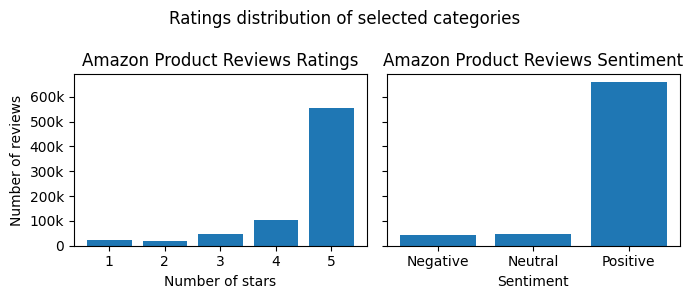

In [12]:
data = df["overall"].value_counts().sort_index().to_dict()
negative = data[1] + data[2]
neutral = data[3]
positive = data[4] + data[5]
sentiment_data = {"Negative": negative, "Neutral": neutral, "Positive": positive}

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7, 3))
ax[0].bar(data.keys(), data.values())
ax[0].set_xlabel('Number of stars')
ax[0].set_ylabel('Number of reviews')
ax[0].set_yticks([0, 100000, 200000, 300000, 400000, 500000, 600000, 700000],
                 ['0', '100k', '200k', '300k', '400k', '500k', '600k', '700k'])
ax[0].set_title('Amazon Product Reviews Ratings')
ax[1].bar(sentiment_data.keys(), sentiment_data.values())
ax[1].set_xlabel('Sentiment')
ax[1].set_title('Amazon Product Reviews Sentiment')
plt.suptitle("Ratings distribution of selected categories")
plt.tight_layout()
plt.show()

In [13]:
df["sentiment"] = df["overall"].apply(lambda x: 1 if x > 3 else -1 if x < 3 else 0)
df["reviewTextWithSummary"] = df["summary"] + " " + df["reviewText"]
df.drop(["overall", "summary"], axis=1, inplace=True)
df.head()

reviewText  verified  sentiment  \
0                   As advertised. Reasonably priced      True          1   
1  Like the oder and the feel when I put it on my...      True          1   
2  I bought this to smell nice after I shave.  Wh...      True         -1   
3  HEY!! I am an Aqua Velva Man and absolutely lo...     False          1   
4  If you ever want to feel pampered by a shampoo...      True          1   

                               reviewTextWithSummary  
0        Five Stars As advertised. Reasonably priced  
1  Good for the face Like the oder and the feel w...  
2  Smells awful I bought this to smell nice after...  
3  Truth is There IS Nothing Like an AQUA VELVA M...  
4  Bvlgari Shampoo If you ever want to feel pampe...

In [14]:
df["sentiment"].value_counts()

sentiment
 1    657241
 0     47109
-1     44501
Name: count, dtype: int64

In [15]:
df.head()

reviewText  verified  sentiment  \
0                   As advertised. Reasonably priced      True          1   
1  Like the oder and the feel when I put it on my...      True          1   
2  I bought this to smell nice after I shave.  Wh...      True         -1   
3  HEY!! I am an Aqua Velva Man and absolutely lo...     False          1   
4  If you ever want to feel pampered by a shampoo...      True          1   

                               reviewTextWithSummary  
0        Five Stars As advertised. Reasonably priced  
1  Good for the face Like the oder and the feel w...  
2  Smells awful I bought this to smell nice after...  
3  Truth is There IS Nothing Like an AQUA VELVA M...  
4  Bvlgari Shampoo If you ever want to feel pampe...

In [16]:
STOP_WORDS = set(stopwords.words("english"))

In [17]:
def preprocess_text(sentence, stop, type_proc=None):
    words = []
    for word in sentence.lower().strip().split():

        word = re.sub("\d", "", word)
        word = re.sub("[^\w\s]", "", word)

        if word not in stop and word != "":
            words.append(preprocess_type(word, type_proc))

    return " ".join(words)

In [18]:
def preprocess_type(word, type_proc):
    if type_proc == baseline:
        return word
    elif type_proc == stem:
        return PorterStemmer().stem(word)
    elif type_proc == lem:
        return WordNetLemmatizer().lemmatize(word)
    else:
        raise ValueError("Invalid Preprocessing Type")

In [19]:
positive_text_raw = df[df["sentiment"] == 1]["reviewText"].values
negative_text_raw = df[df["sentiment"] == -1]["reviewText"].values
neutral_text_raw = df[df["sentiment"] == 0]["reviewText"].values
print("senitments")

positive_text_with_summary_raw = df[df["sentiment"] == 1][ "reviewTextWithSummary" ].values
negative_text_with_summary_raw = df[df["sentiment"] == -1][ "reviewTextWithSummary" ].values
neutral_text_with_summary_raw = df[df["sentiment"] == 0][ "reviewTextWithSummary" ].values
print("senitments with summary")

positive_text_baseline = [ preprocess_text(x, STOP_WORDS, baseline) for x in positive_text_raw ]
negative_text_baseline = [ preprocess_text(x, STOP_WORDS, baseline) for x in negative_text_raw ]
neutral_text_baseline = [ preprocess_text(x, STOP_WORDS, baseline) for x in neutral_text_raw ]
print("senitments baseline")

positive_text_with_summary_baseline = [ preprocess_text(x, STOP_WORDS, baseline) for x in positive_text_with_summary_raw ]
negative_text_with_summary_baseline = [ preprocess_text(x, STOP_WORDS, baseline) for x in negative_text_with_summary_raw ]
neutral_text_with_summary_baseline = [ preprocess_text(x, STOP_WORDS, baseline) for x in neutral_text_with_summary_raw ]
print("senitments with summary baseline")

positive_text_stem = [preprocess_text(x, STOP_WORDS, stem) for x in positive_text_raw]
negative_text_stem = [preprocess_text(x, STOP_WORDS, stem) for x in negative_text_raw]
neutral_text_stem = [preprocess_text(x, STOP_WORDS, stem) for x in neutral_text_raw]
print("senitments stematized")

positive_text_with_summary_stem = [ preprocess_text(x, STOP_WORDS, stem) for x in positive_text_with_summary_raw ]
negative_text_with_summary_stem = [ preprocess_text(x, STOP_WORDS, stem) for x in negative_text_with_summary_raw ]
neutral_text_with_summary_stem = [ preprocess_text(x, STOP_WORDS, stem) for x in neutral_text_with_summary_raw ]
print("senitments with summary stematized")

positive_text_lem = [preprocess_text(x, STOP_WORDS, lem) for x in positive_text_raw]
negative_text_lem = [preprocess_text(x, STOP_WORDS, lem) for x in negative_text_raw]
neutral_text_lem = [preprocess_text(x, STOP_WORDS, lem) for x in neutral_text_raw]
print("senitments lemmatized")

positive_text_with_summary_lem = [ preprocess_text(x, STOP_WORDS, lem) for x in positive_text_with_summary_raw ]
negative_text_with_summary_lem = [ preprocess_text(x, STOP_WORDS, lem) for x in negative_text_with_summary_raw ]
neutral_text_with_summary_lem = [ preprocess_text(x, STOP_WORDS, lem) for x in neutral_text_with_summary_raw ]
print("senitments with summary lemmatized")

senitments
senitments with summary
senitments baseline
senitments with summary baseline
senitments stematized
senitments with summary stematized
senitments lemmatized
senitments with summary lemmatized


In [20]:
texts = {
    "positive_text_raw": positive_text_raw,
    "negative_text_raw": negative_text_raw,
    "neutral_text_raw": neutral_text_raw,
    "positive_text_with_summary_raw": positive_text_with_summary_raw,
    "negative_text_with_summary_raw": negative_text_with_summary_raw,
    "neutral_text_with_summary_raw": neutral_text_with_summary_raw,
    "positive_text_baseline": positive_text_baseline,
    "negative_text_baseline": negative_text_baseline,
    "neutral_text_baseline": neutral_text_baseline,
    "positive_text_with_summary_baseline": positive_text_with_summary_baseline,
    "negative_text_with_summary_baseline": negative_text_with_summary_baseline,
    "neutral_text_with_summary_baseline": neutral_text_with_summary_baseline,
    "positive_text_stem": positive_text_stem,
    "negative_text_stem": negative_text_stem,
    "neutral_text_stem": neutral_text_stem,
    "positive_text_with_summary_stem": positive_text_with_summary_stem,
    "negative_text_with_summary_stem": negative_text_with_summary_stem,
    "neutral_text_with_summary_stem": neutral_text_with_summary_stem,
    "positive_text_lem": positive_text_lem,
    "negative_text_lem": negative_text_lem,
    "neutral_text_lem": neutral_text_lem,
    "positive_text_with_summary_lem": positive_text_with_summary_lem,
    "negative_text_with_summary_lem": negative_text_with_summary_lem,
    "neutral_text_with_summary_lem": neutral_text_with_summary_lem,
}

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
def plot_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, random_state=random_state).generate(
        text
    )
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

In [23]:
def plot_top_words_count(text, title, n=10):
    words = text.split()
    words = [word for word in words if word not in STOP_WORDS]
    words = pd.Series(words).value_counts().head(n)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=words.values, y=words.index)
    plt.title(title)
    plt.show()

In [24]:
def plot_top_words_count_subplots(pos, neg, neu, title, n=10):
    fig, ax = plt.subplots(1, 3, figsize=(9, 3.5), sharex=True)
    for i, text in enumerate([pos, neg, neu]):
        words = text.split()
        words = [word for word in words if word not in STOP_WORDS]
        words = pd.Series(words).value_counts(normalize=True).head(n) * 100
        ax[i].set_title(["Positive", "Negative", "Neutral"][i])
        ax[i].set_xlabel("Percentage")
        sns.barplot(x=words.values, y=words.index, ax=ax[i])
    ax[0].set_ylabel("Words")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [25]:
code_gen = False
if code_gen:
    for key, value in texts.items():
        print(
            f"""
# %%
text = " ".join({key})
plot_word_cloud(text, "{key} word cloud".replace("_", " "))
plot_top_words_count(text, "{key} top 10 words count".replace("_", " "), 10)
              """
        )

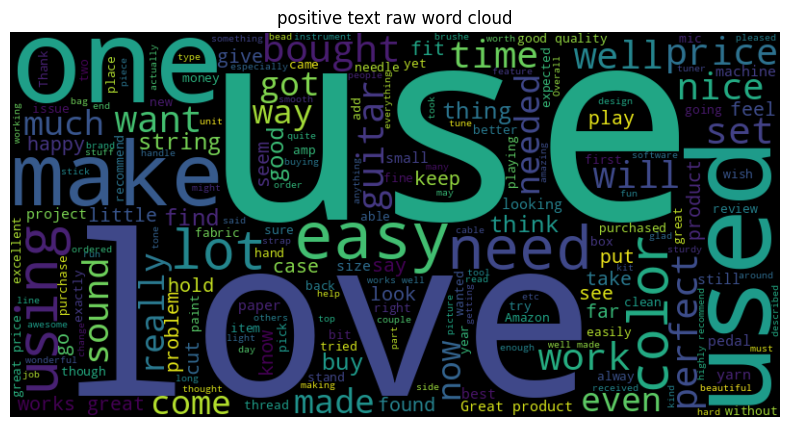

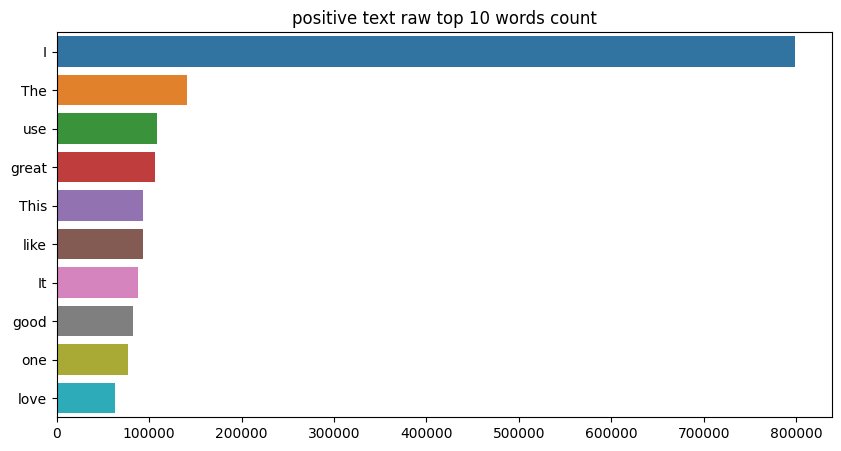

In [26]:
text = " ".join(positive_text_raw)
plot_word_cloud(text, "positive_text_raw word cloud".replace("_", " "))
plot_top_words_count(text, "positive_text_raw top 10 words count".replace("_", " "), 10)

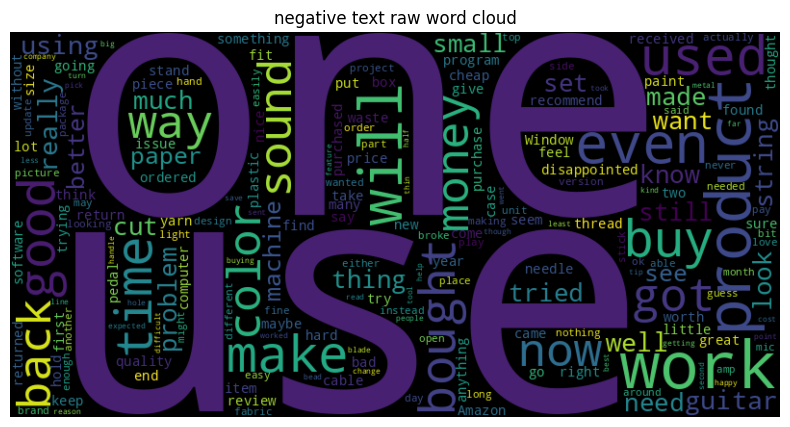

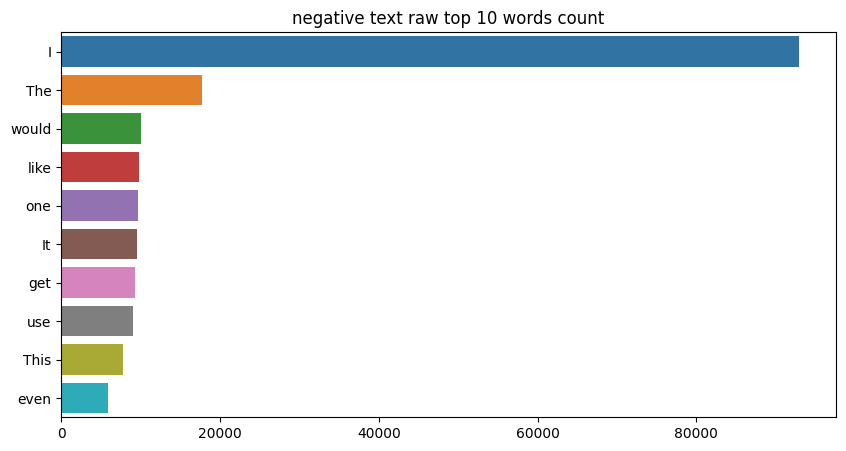

In [27]:
text = " ".join(negative_text_raw)
plot_word_cloud(text, "negative_text_raw word cloud".replace("_", " "))
plot_top_words_count(text, "negative_text_raw top 10 words count".replace("_", " "), 10)

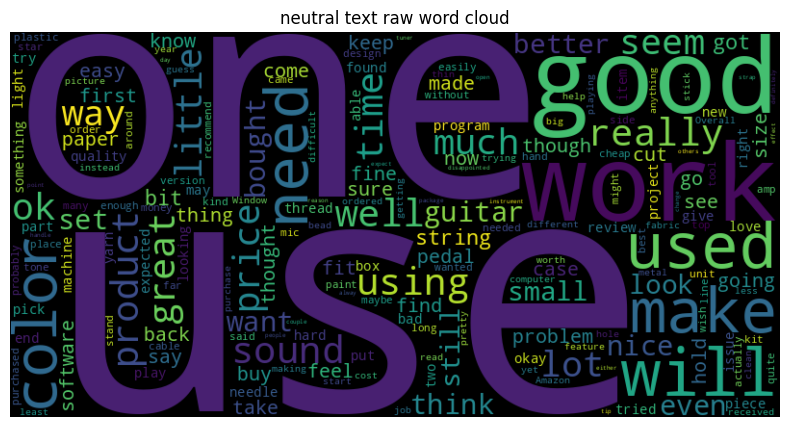

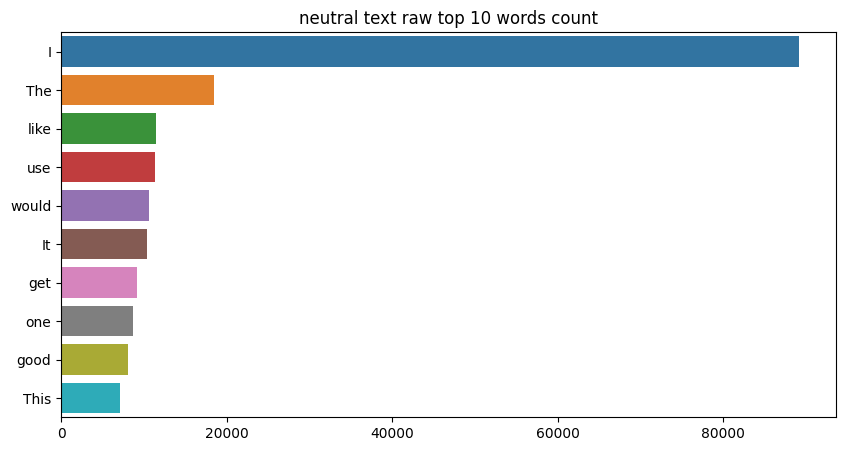

In [28]:
text = " ".join(neutral_text_raw)
plot_word_cloud(text, "neutral_text_raw word cloud".replace("_", " "))
plot_top_words_count(text, "neutral_text_raw top 10 words count".replace("_", " "), 10)

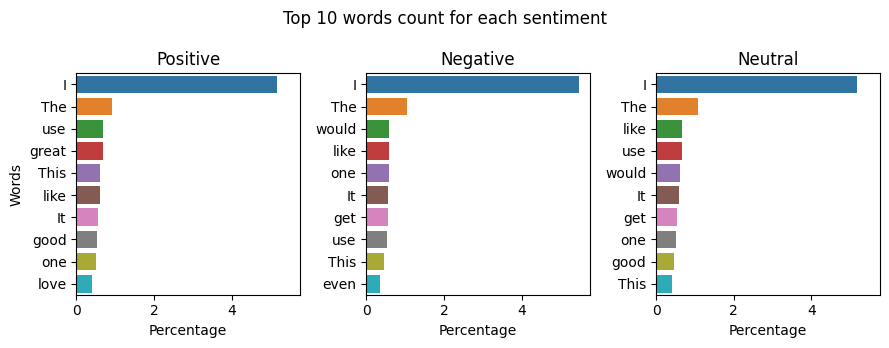

In [29]:
plot_top_words_count_subplots(
    " ".join(positive_text_raw),
    " ".join(negative_text_raw),
    " ".join(neutral_text_raw),
    "Top 10 words count for each sentiment",
)

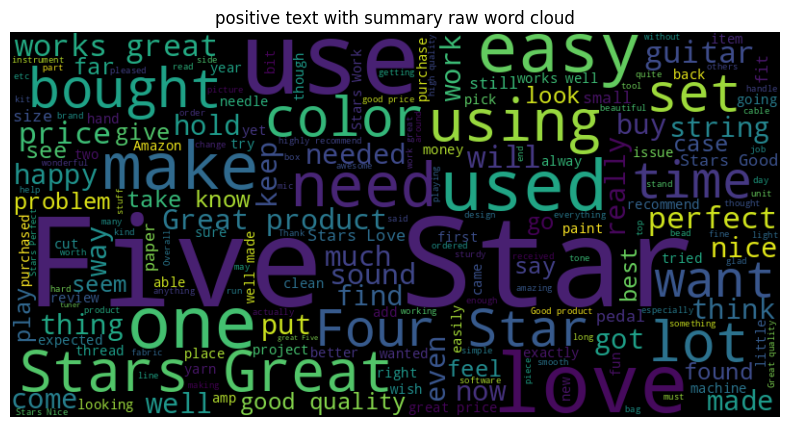

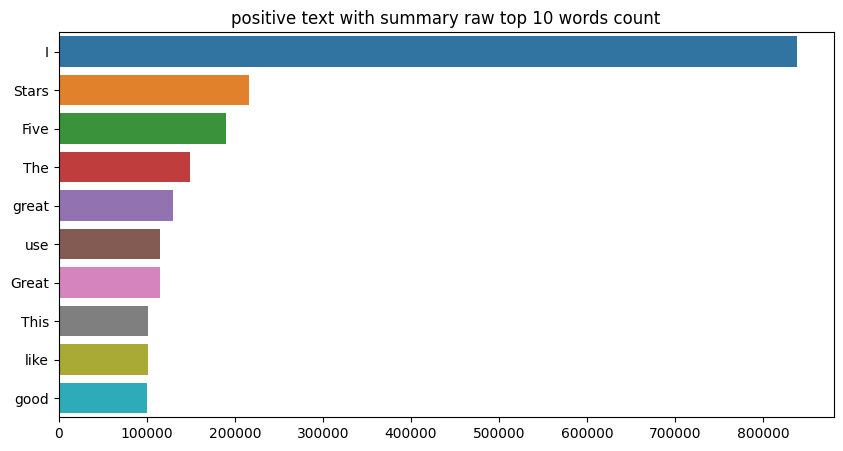

In [30]:
text = " ".join(positive_text_with_summary_raw)
plot_word_cloud(text, "positive_text_with_summary_raw word cloud".replace("_", " "))
plot_top_words_count(text, "positive_text_with_summary_raw top 10 words count".replace("_", " "), 10)

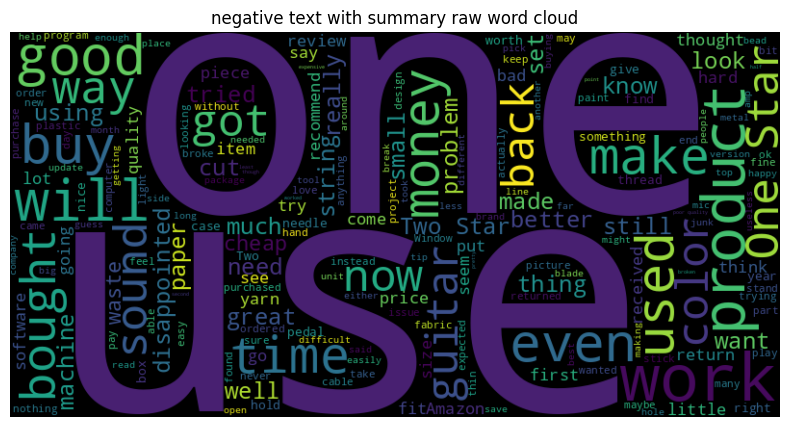

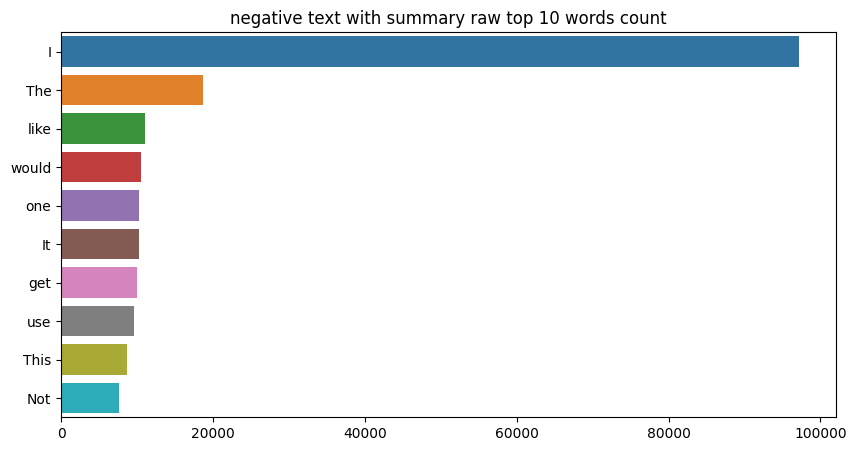

In [31]:
text = " ".join(negative_text_with_summary_raw)
plot_word_cloud(text, "negative_text_with_summary_raw word cloud".replace("_", " "))
plot_top_words_count(text, "negative_text_with_summary_raw top 10 words count".replace("_", " "), 10)

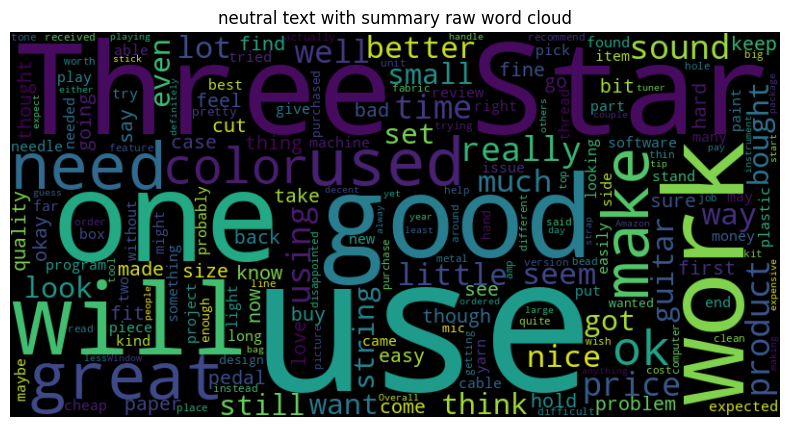

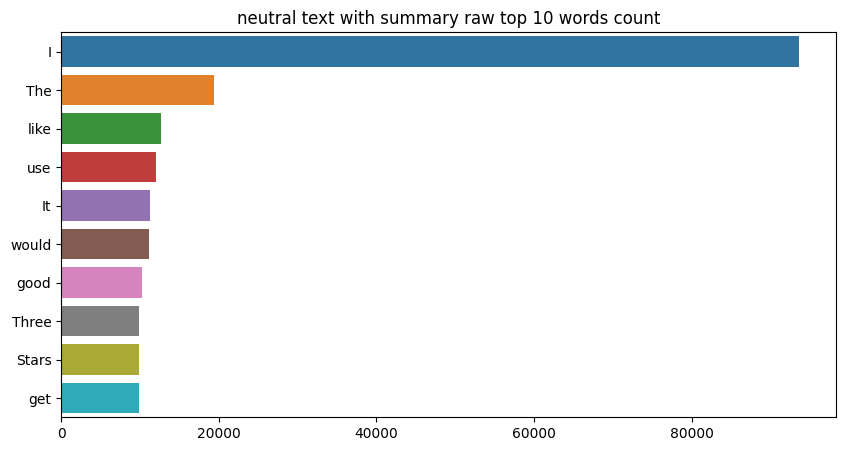

In [32]:
text = " ".join(neutral_text_with_summary_raw)
plot_word_cloud(text, "neutral_text_with_summary_raw word cloud".replace("_", " "))
plot_top_words_count(text, "neutral_text_with_summary_raw top 10 words count".replace("_", " "), 10)

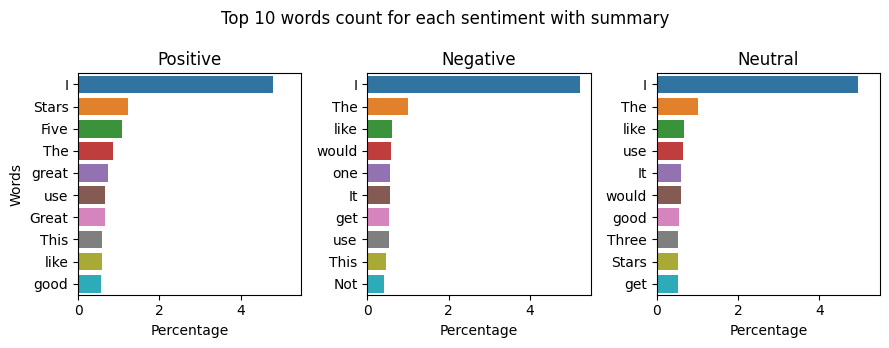

In [33]:
plot_top_words_count_subplots(
    " ".join(positive_text_with_summary_raw),
    " ".join(negative_text_with_summary_raw),
    " ".join(neutral_text_with_summary_raw),
    "Top 10 words count for each sentiment with summary",
)

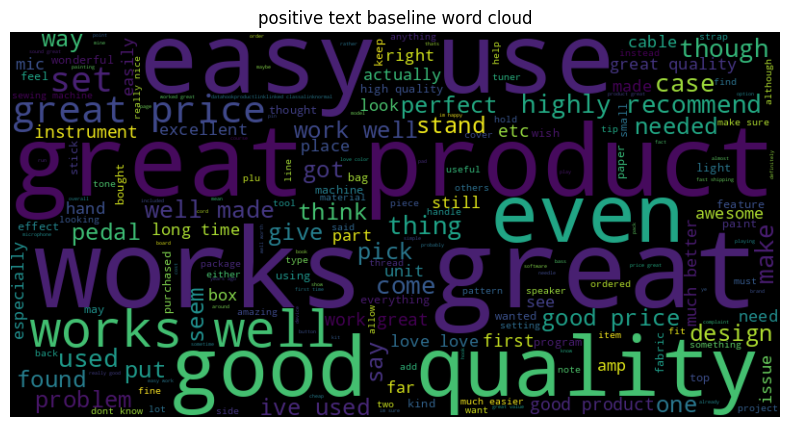

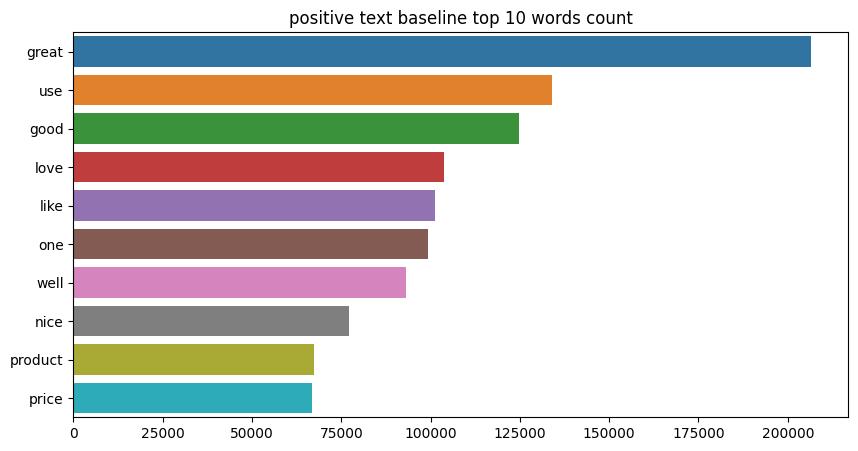

In [34]:
text = " ".join(positive_text_baseline)
plot_word_cloud(text, "positive_text_baseline word cloud".replace("_", " "))
plot_top_words_count(text, "positive_text_baseline top 10 words count".replace("_", " "), 10)

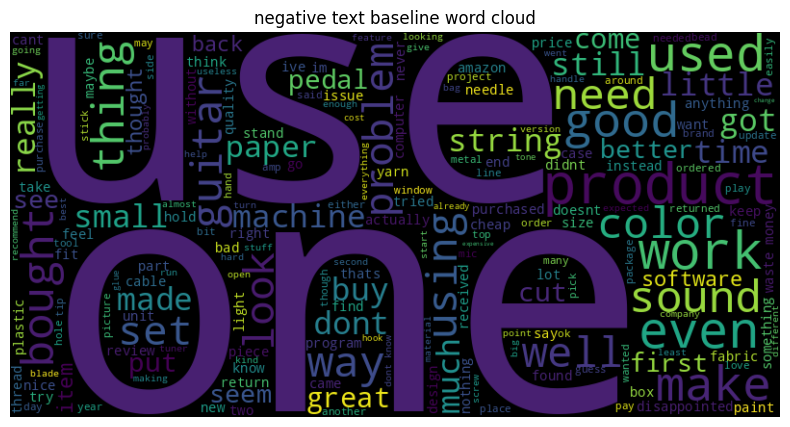

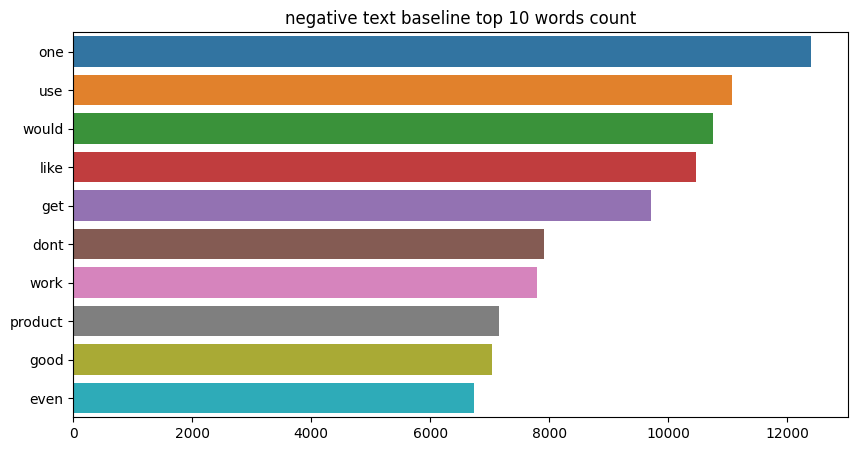

In [35]:
text = " ".join(negative_text_baseline)
plot_word_cloud(text, "negative_text_baseline word cloud".replace("_", " "))
plot_top_words_count(text, "negative_text_baseline top 10 words count".replace("_", " "), 10)

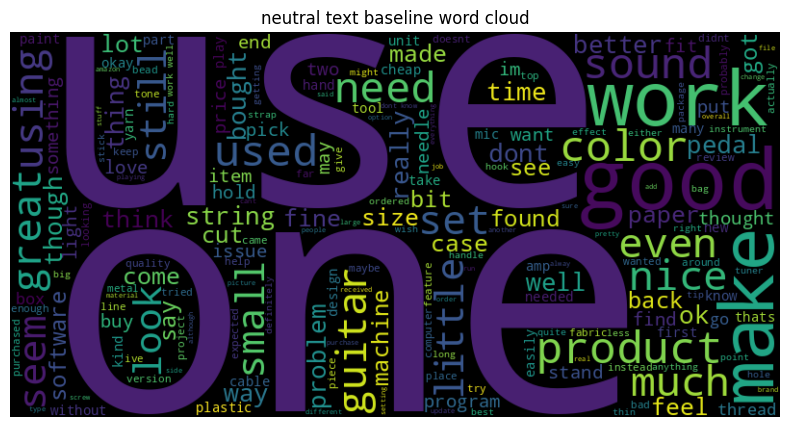

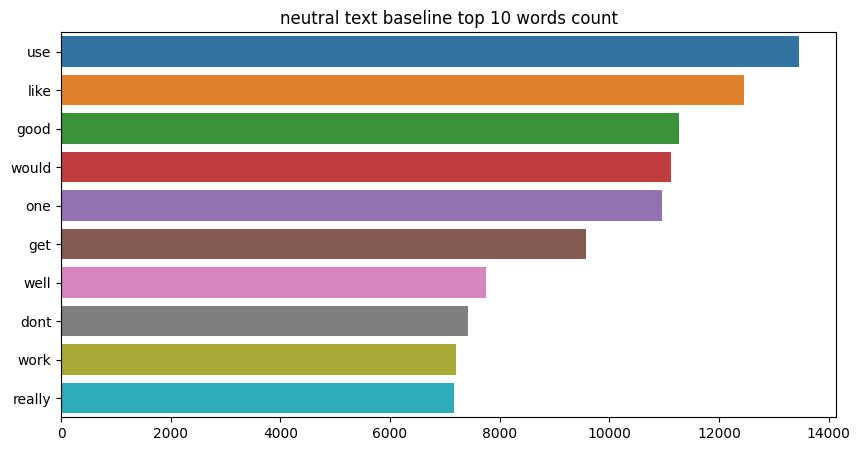

In [36]:
text = " ".join(neutral_text_baseline)
plot_word_cloud(text, "neutral_text_baseline word cloud".replace("_", " "))
plot_top_words_count(text, "neutral_text_baseline top 10 words count".replace("_", " "), 10)

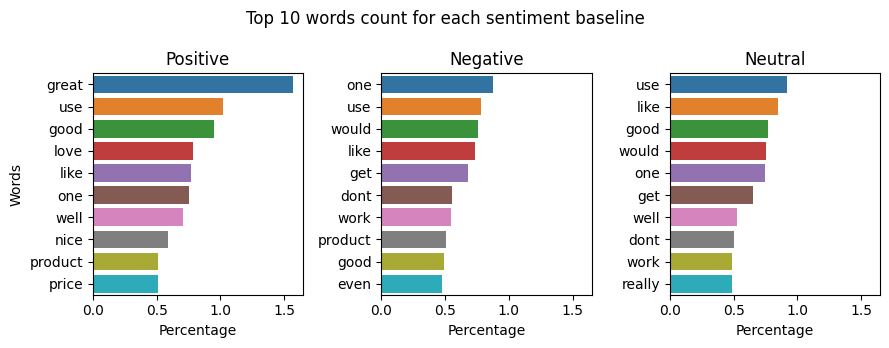

In [37]:
plot_top_words_count_subplots(
    " ".join(positive_text_baseline),
    " ".join(negative_text_baseline),
    " ".join(neutral_text_baseline),
    "Top 10 words count for each sentiment baseline",
)

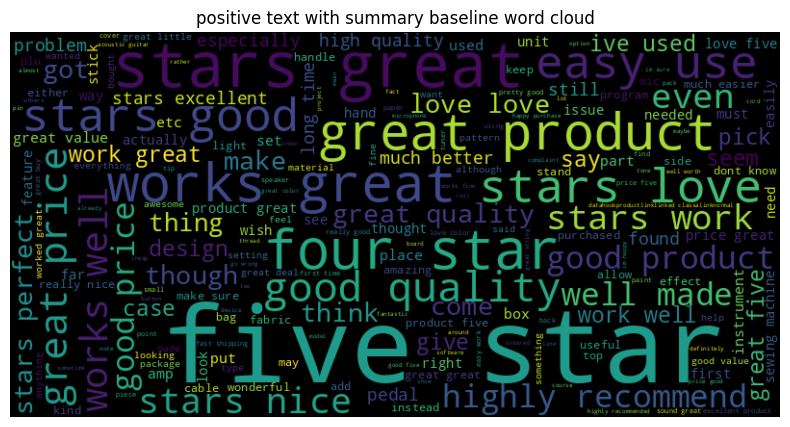

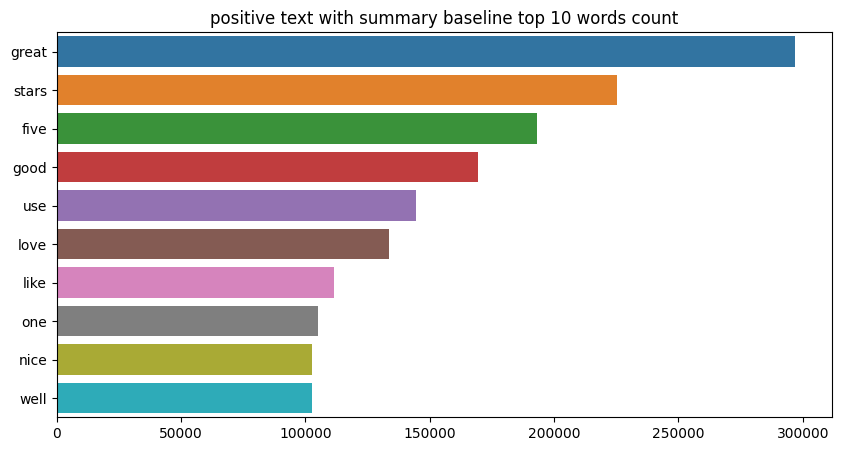

In [38]:
text = " ".join(positive_text_with_summary_baseline)
plot_word_cloud(text, "positive_text_with_summary_baseline word cloud".replace("_", " "))
plot_top_words_count(text, "positive_text_with_summary_baseline top 10 words count".replace("_", " "), 10)

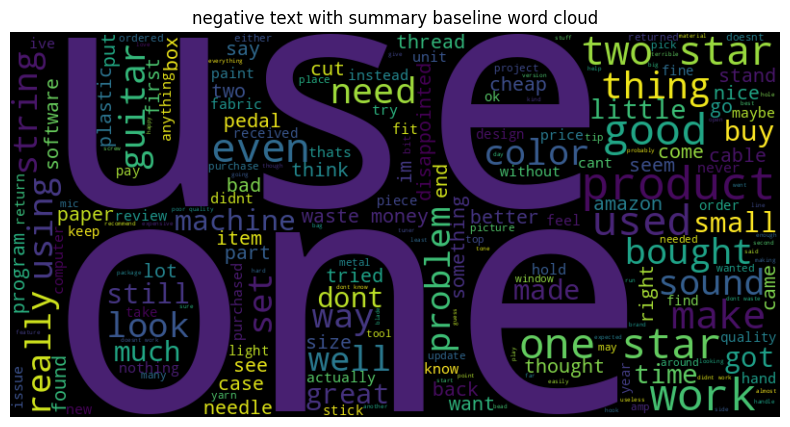

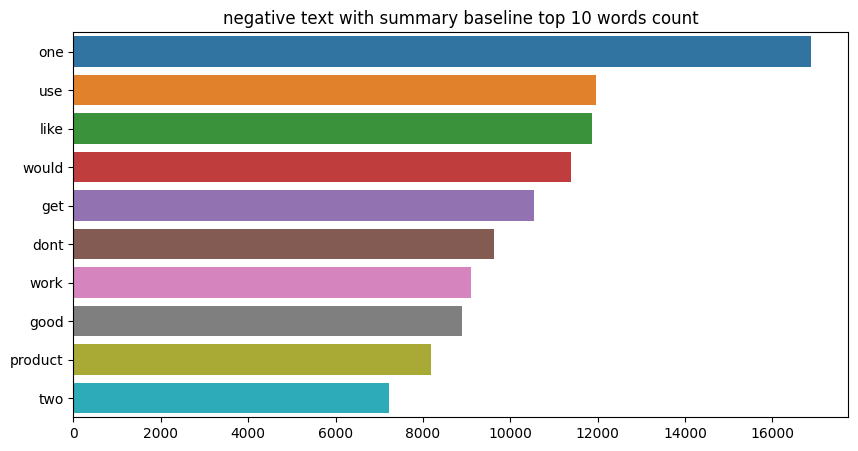

In [39]:
text = " ".join(negative_text_with_summary_baseline)
plot_word_cloud(text, "negative_text_with_summary_baseline word cloud".replace("_", " "))
plot_top_words_count(text, "negative_text_with_summary_baseline top 10 words count".replace("_", " "), 10)

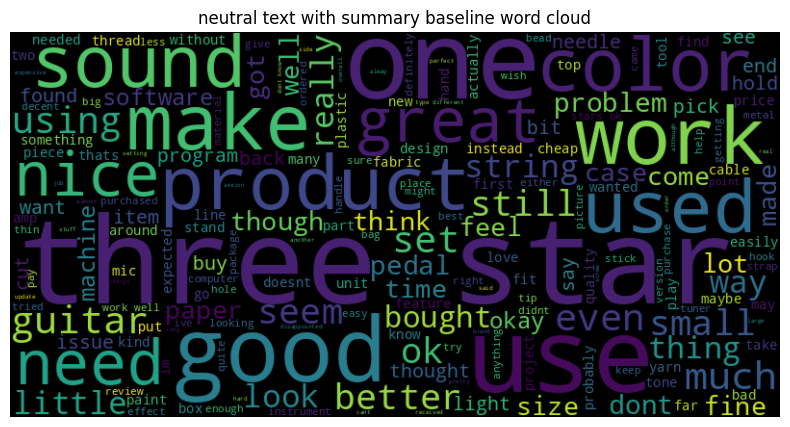

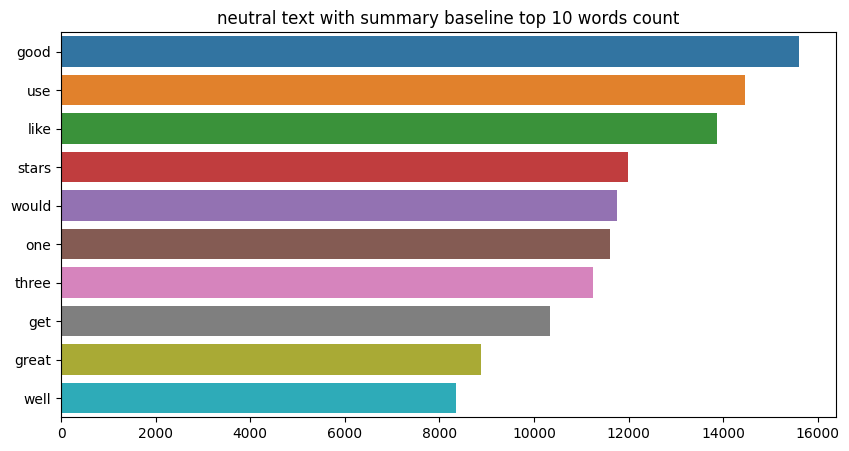

In [40]:
text = " ".join(neutral_text_with_summary_baseline)
plot_word_cloud(text, "neutral_text_with_summary_baseline word cloud".replace("_", " "))
plot_top_words_count(text, "neutral_text_with_summary_baseline top 10 words count".replace("_", " "), 10)

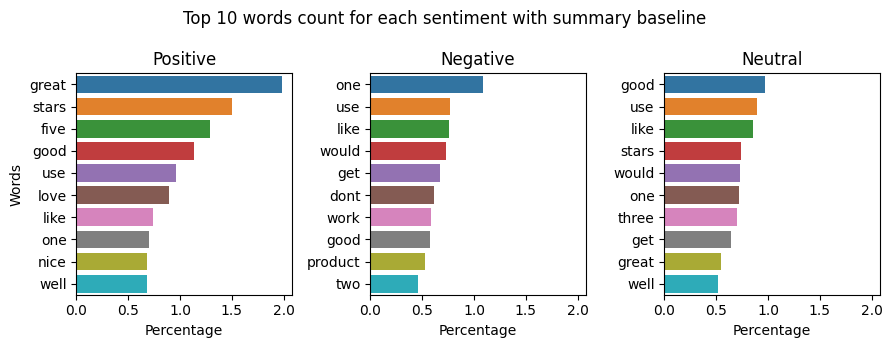

In [41]:
plot_top_words_count_subplots(
    " ".join(positive_text_with_summary_baseline),
    " ".join(negative_text_with_summary_baseline),
    " ".join(neutral_text_with_summary_baseline),
    "Top 10 words count for each sentiment with summary baseline",
)

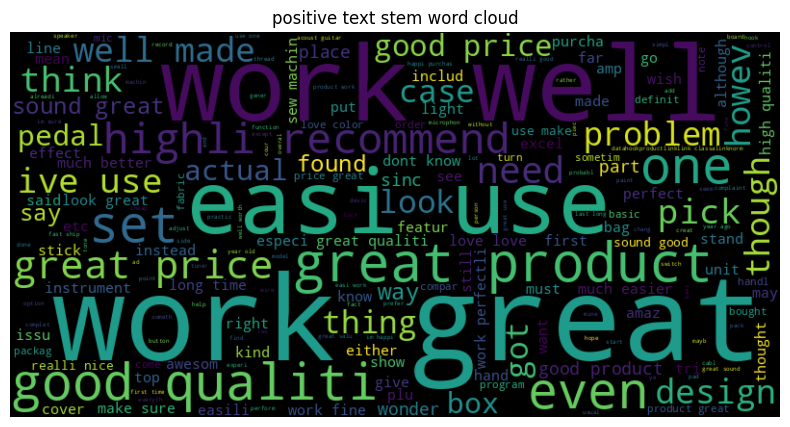

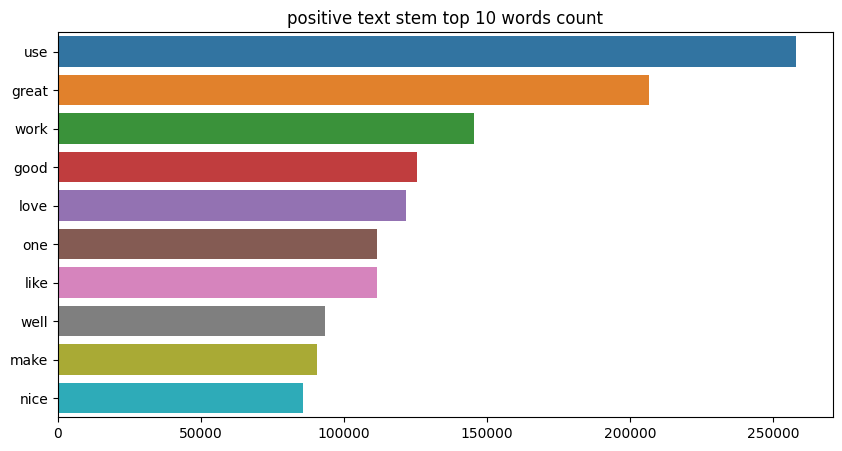

In [42]:
text = " ".join(positive_text_stem)
plot_word_cloud(text, "positive_text_stem word cloud".replace("_", " "))
plot_top_words_count(text, "positive_text_stem top 10 words count".replace("_", " "), 10)

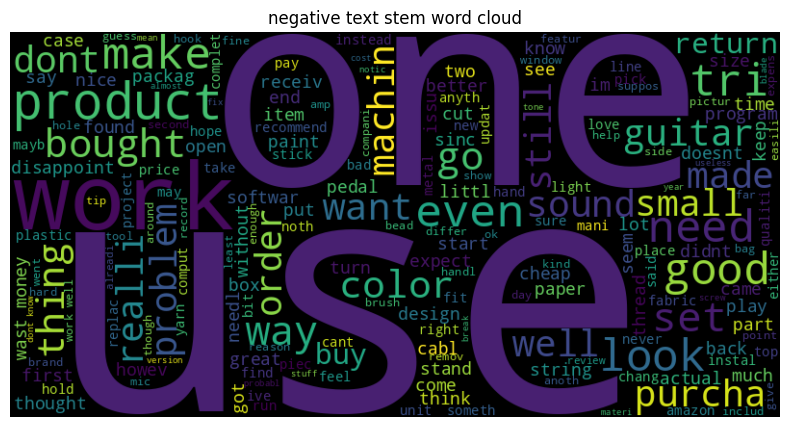

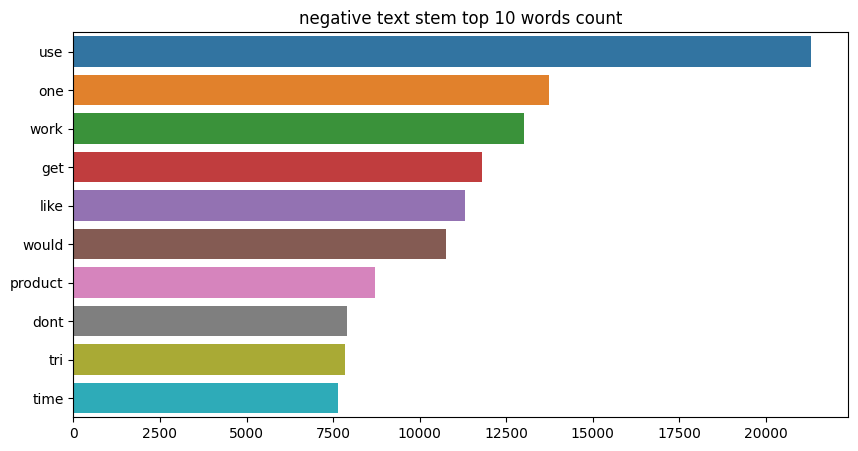

In [43]:
text = " ".join(negative_text_stem)
plot_word_cloud(text, "negative_text_stem word cloud".replace("_", " "))
plot_top_words_count(text, "negative_text_stem top 10 words count".replace("_", " "), 10)

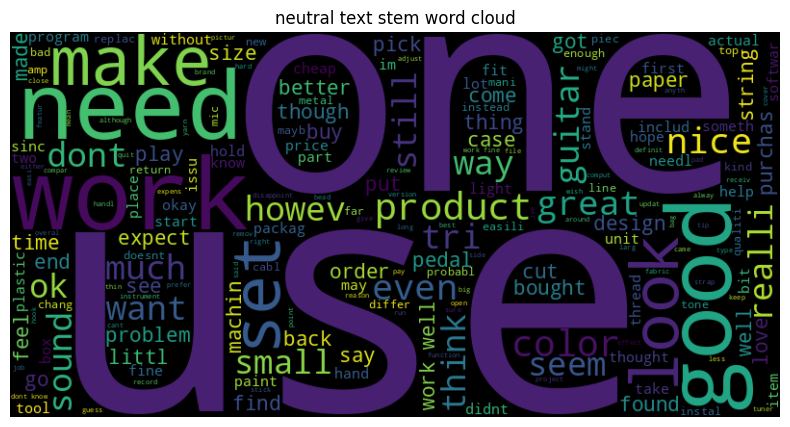

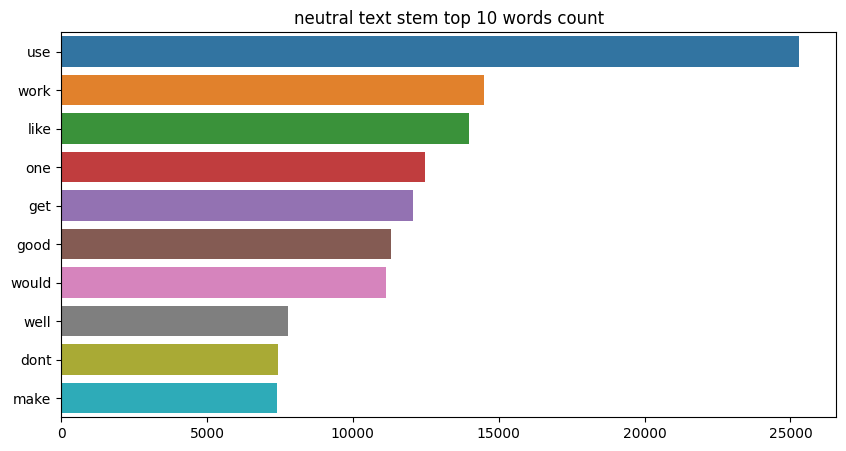

In [44]:
text = " ".join(neutral_text_stem)
plot_word_cloud(text, "neutral_text_stem word cloud".replace("_", " "))
plot_top_words_count(text, "neutral_text_stem top 10 words count".replace("_", " "), 10)

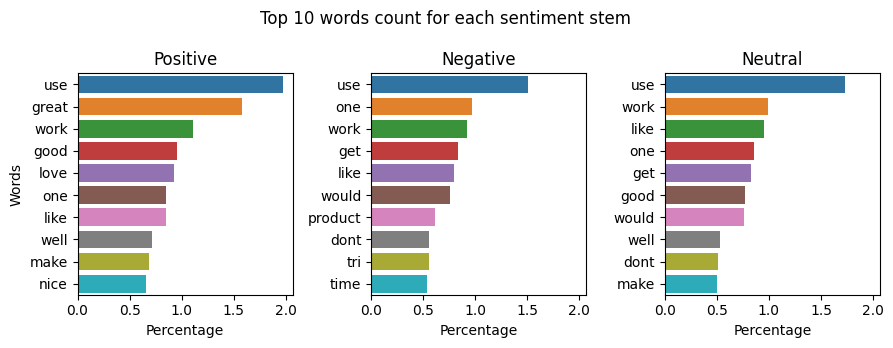

In [45]:
plot_top_words_count_subplots(
    " ".join(positive_text_stem),
    " ".join(negative_text_stem),
    " ".join(neutral_text_stem),
    "Top 10 words count for each sentiment stem",
)

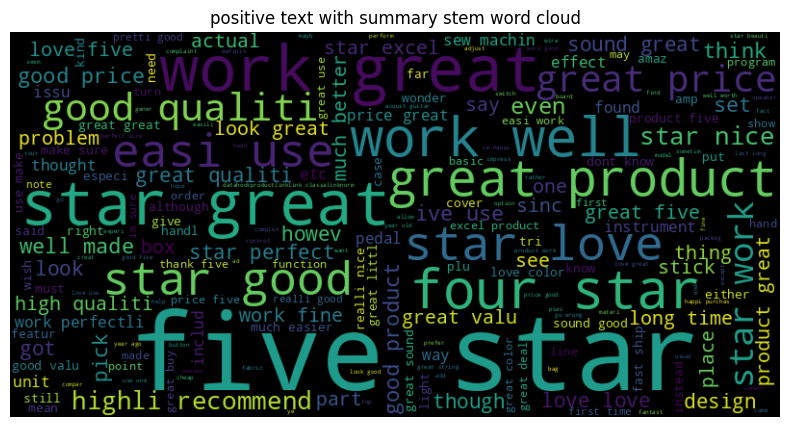

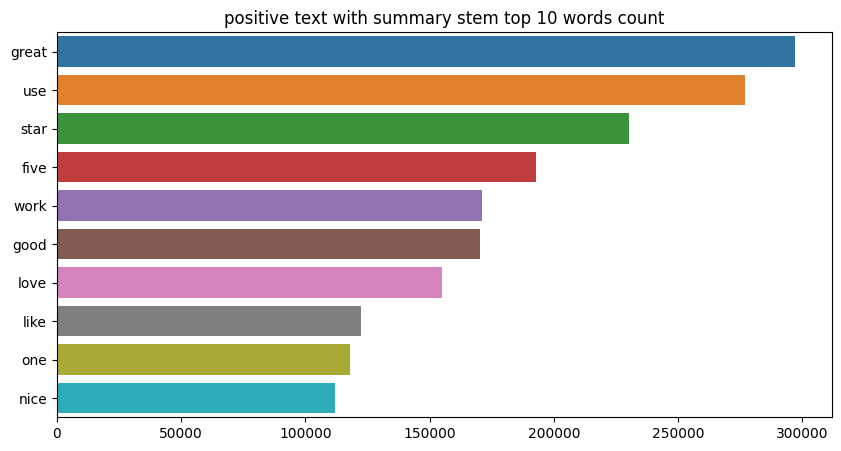

In [46]:
text = " ".join(positive_text_with_summary_stem)
plot_word_cloud(text, "positive_text_with_summary_stem word cloud".replace("_", " "))
plot_top_words_count(text, "positive_text_with_summary_stem top 10 words count".replace("_", " "), 10)

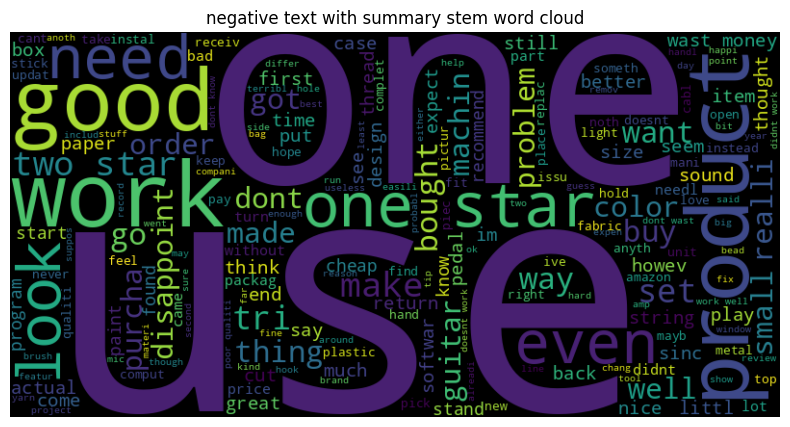

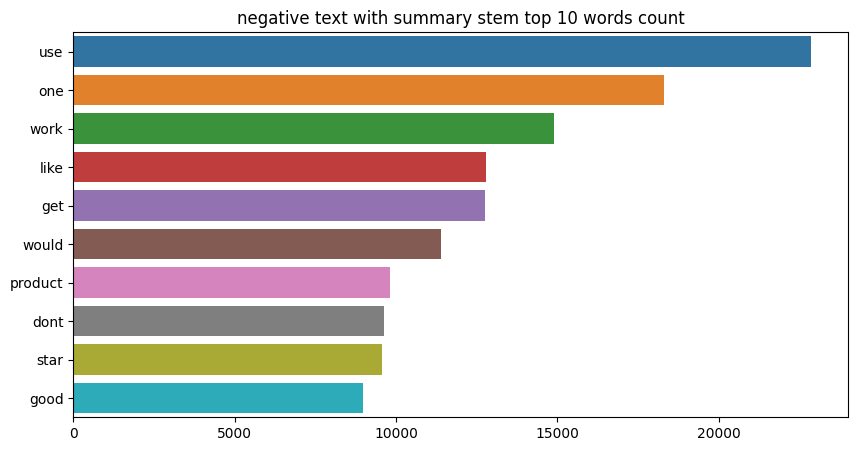

In [47]:
text = " ".join(negative_text_with_summary_stem)
plot_word_cloud(text, "negative_text_with_summary_stem word cloud".replace("_", " "))
plot_top_words_count(text, "negative_text_with_summary_stem top 10 words count".replace("_", " "), 10)

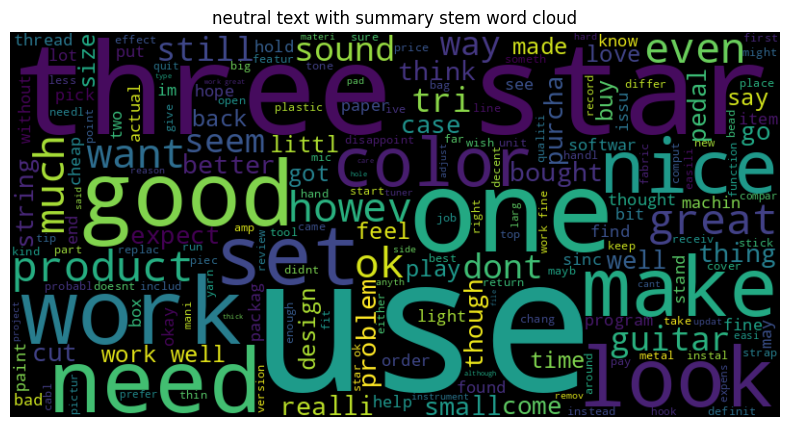

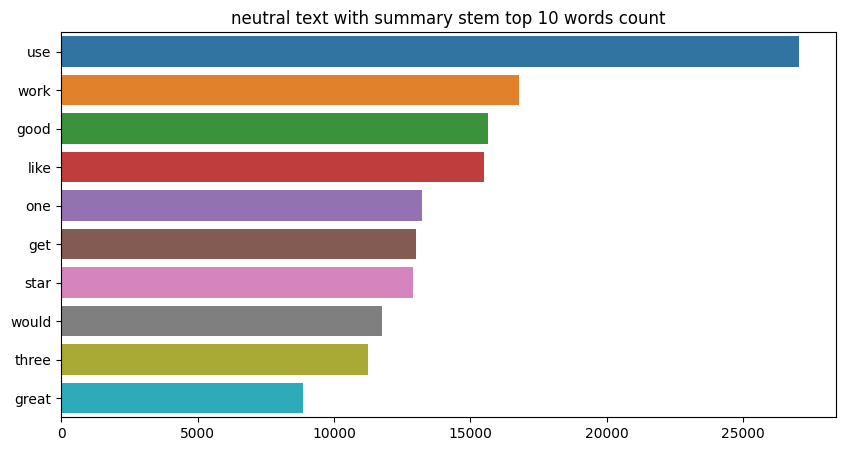

In [48]:
text = " ".join(neutral_text_with_summary_stem)
plot_word_cloud(text, "neutral_text_with_summary_stem word cloud".replace("_", " "))
plot_top_words_count(text, "neutral_text_with_summary_stem top 10 words count".replace("_", " "), 10)

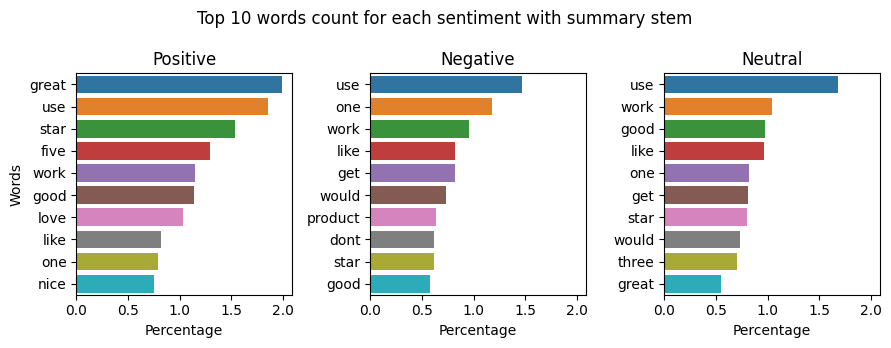

In [49]:
plot_top_words_count_subplots(
    " ".join(positive_text_with_summary_stem),
    " ".join(negative_text_with_summary_stem),
    " ".join(neutral_text_with_summary_stem),
    "Top 10 words count for each sentiment with summary stem",
)

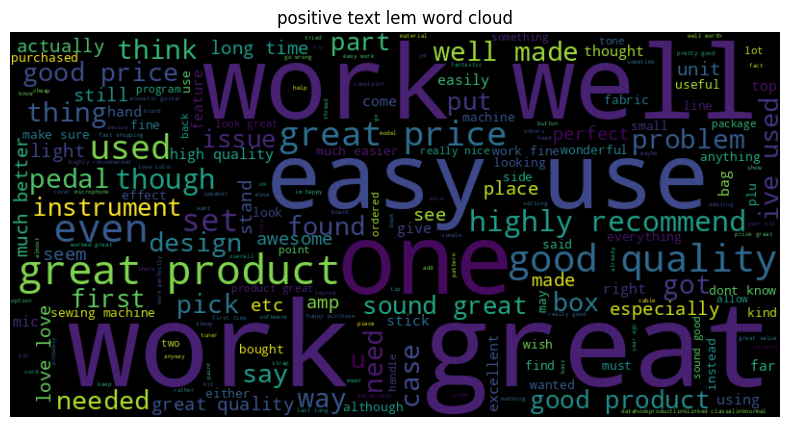

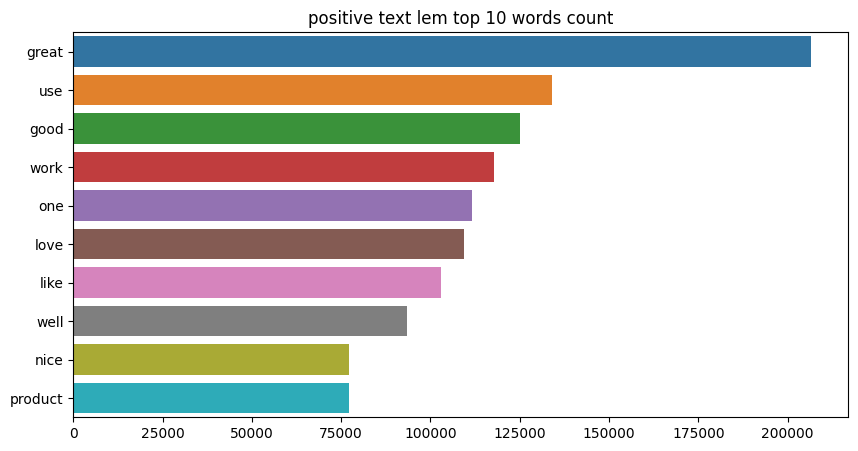

In [50]:
text = " ".join(positive_text_lem)
plot_word_cloud(text, "positive_text_lem word cloud".replace("_", " "))
plot_top_words_count(text, "positive_text_lem top 10 words count".replace("_", " "), 10)

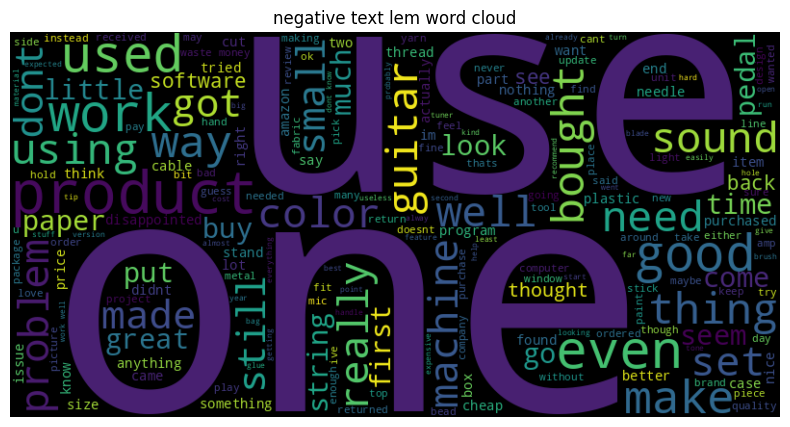

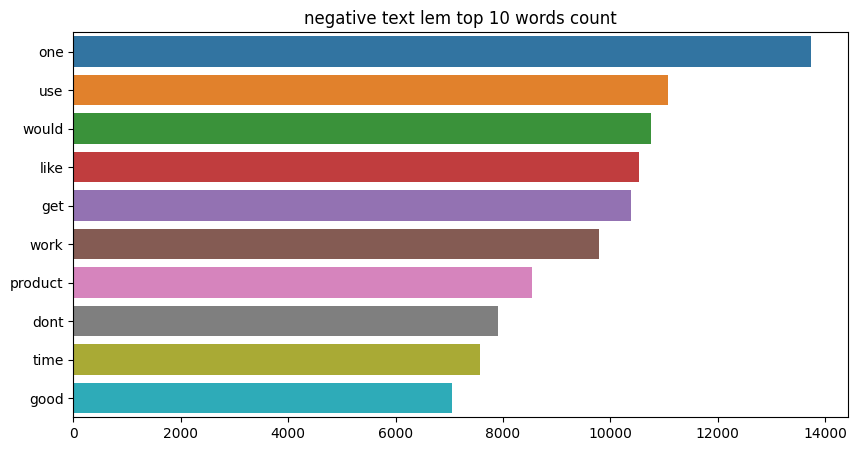

In [51]:
text = " ".join(negative_text_lem)
plot_word_cloud(text, "negative_text_lem word cloud".replace("_", " "))
plot_top_words_count(text, "negative_text_lem top 10 words count".replace("_", " "), 10)

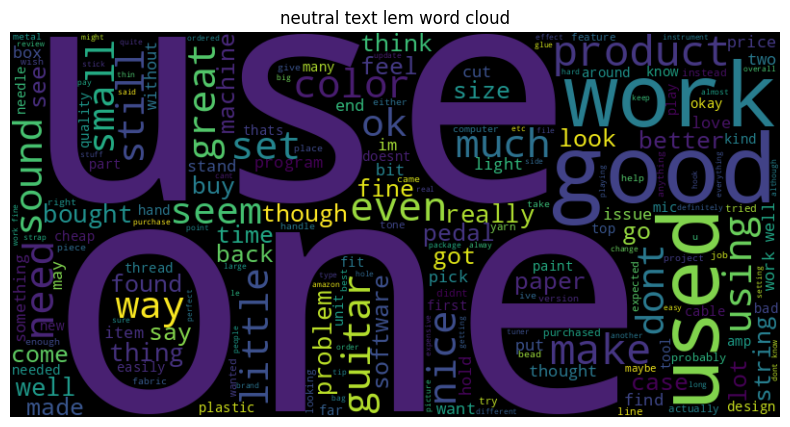

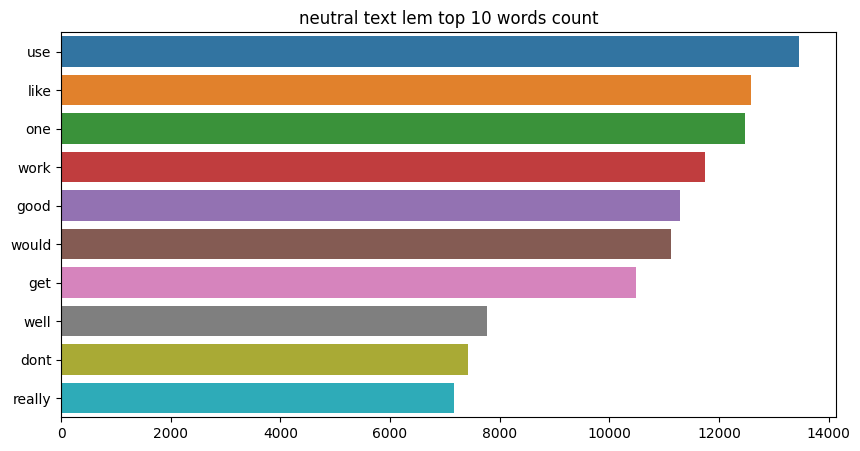

In [52]:
text = " ".join(neutral_text_lem)
plot_word_cloud(text, "neutral_text_lem word cloud".replace("_", " "))
plot_top_words_count(text, "neutral_text_lem top 10 words count".replace("_", " "), 10)

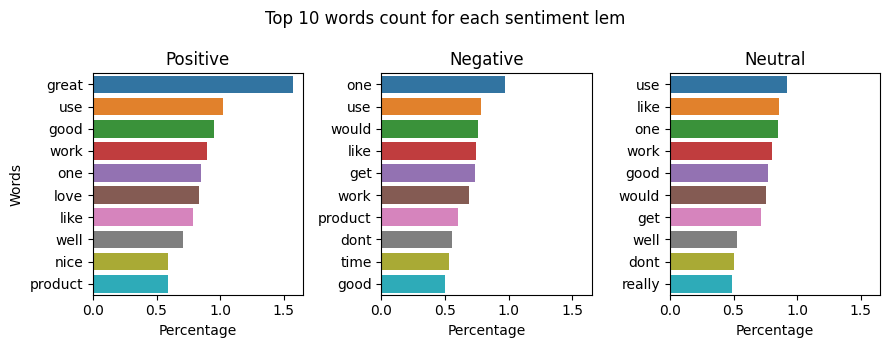

In [53]:
plot_top_words_count_subplots(
    " ".join(positive_text_lem),
    " ".join(negative_text_lem),
    " ".join(neutral_text_lem),
    "Top 10 words count for each sentiment lem",
)

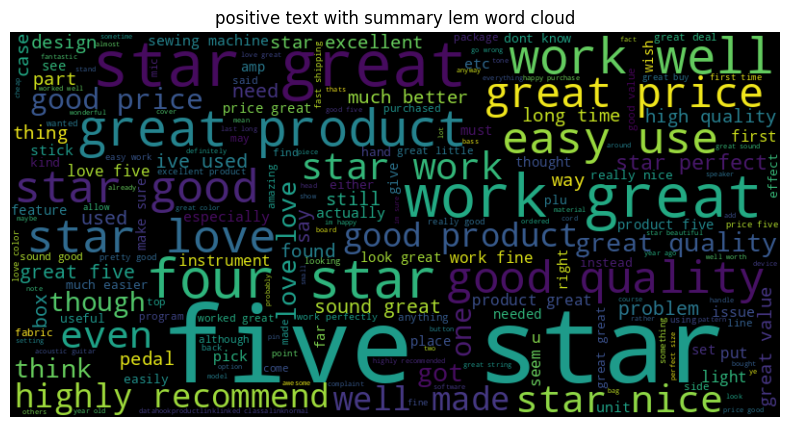

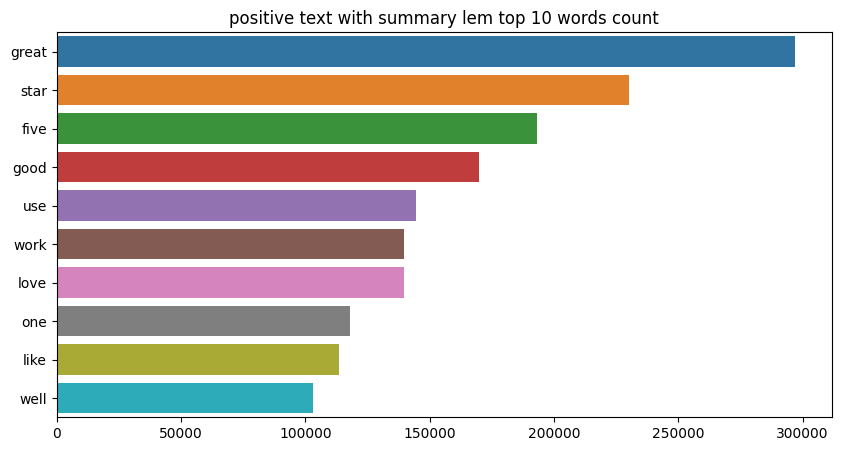

In [54]:
text = " ".join(positive_text_with_summary_lem)
plot_word_cloud(text, "positive_text_with_summary_lem word cloud".replace("_", " "))
plot_top_words_count(text, "positive_text_with_summary_lem top 10 words count".replace("_", " "), 10)

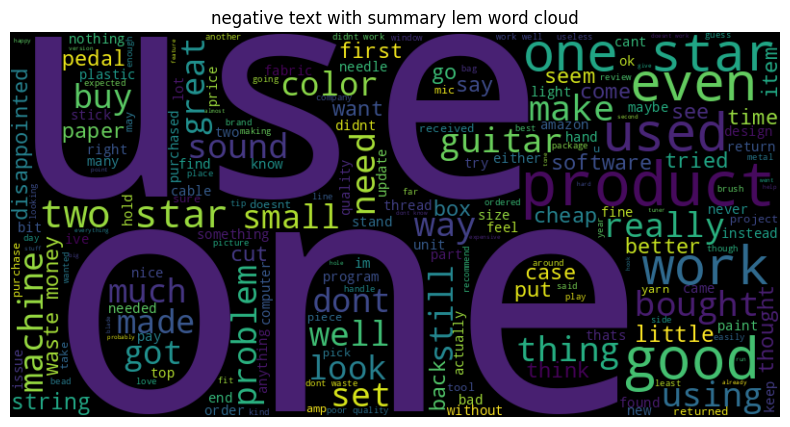

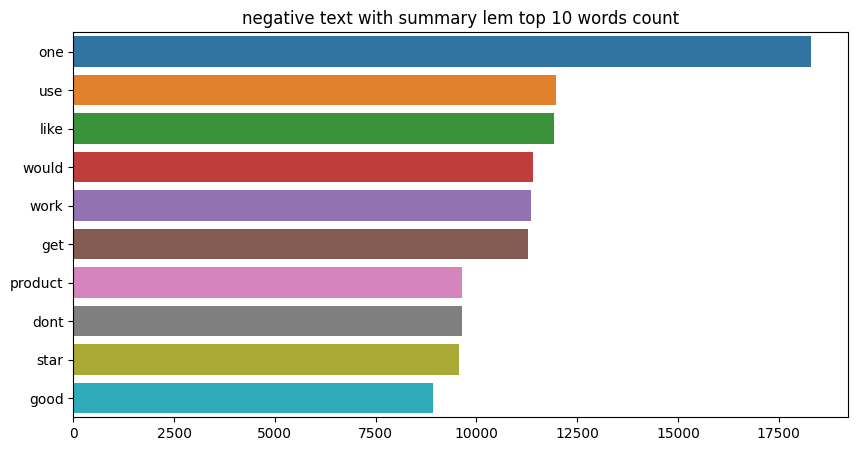

In [55]:
text = " ".join(negative_text_with_summary_lem)
plot_word_cloud(text, "negative_text_with_summary_lem word cloud".replace("_", " "))
plot_top_words_count(text, "negative_text_with_summary_lem top 10 words count".replace("_", " "), 10)

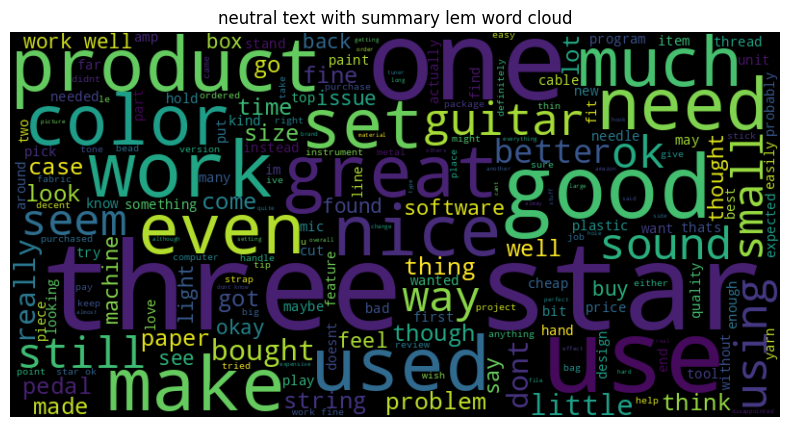

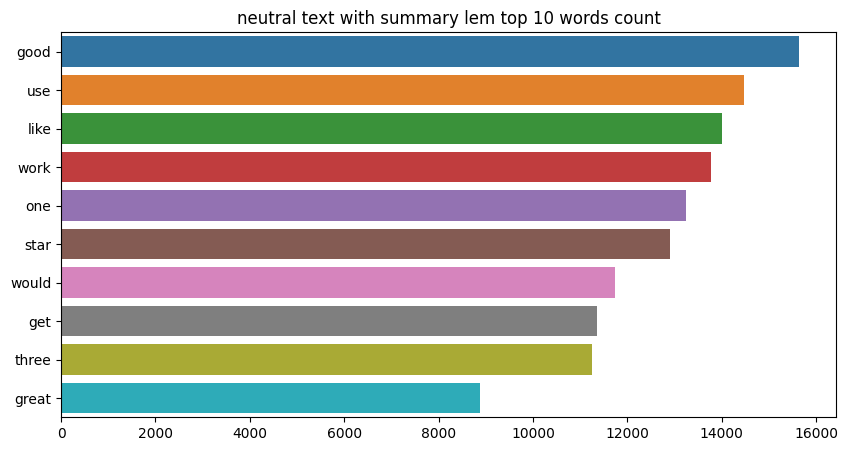

In [56]:
text = " ".join(neutral_text_with_summary_lem)
plot_word_cloud(text, "neutral_text_with_summary_lem word cloud".replace("_", " "))
plot_top_words_count(text, "neutral_text_with_summary_lem top 10 words count".replace("_", " "), 10)

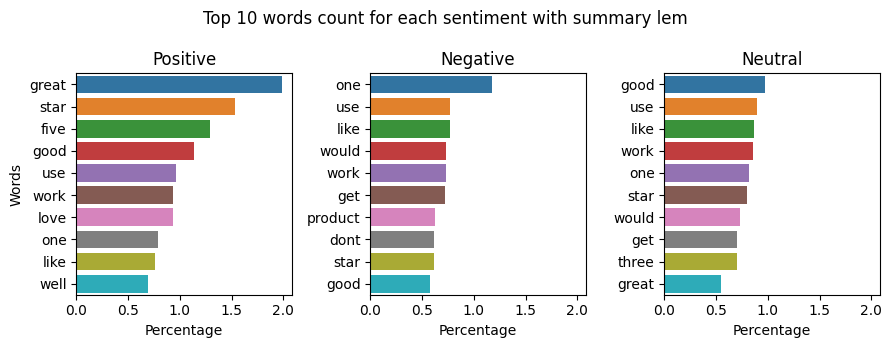

In [57]:
plot_top_words_count_subplots(
    " ".join(positive_text_with_summary_lem),
    " ".join(negative_text_with_summary_lem),
    " ".join(neutral_text_with_summary_lem),
    "Top 10 words count for each sentiment with summary lem",
)